In [1]:
import torch
import pandas as pd
import os
import glob
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms,models
from torch.utils.data import DataLoader,random_split
from torchvision.models import densenet121
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, roc_curve, auc
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Main
from ChexnetTrainer import ChexnetTrainer
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
device = torch.device("cuda:0")
print(device)

cuda:0


In [5]:
class PneumoniaDataset(Dataset):
    def __init__(self,data_dir, label_file, transform=None):

        self.data_dir = data_dir
        self.transform = transform
        self.labels_df = pd.read_excel(label_file)
        #if label contains Pneumothorax = 1 else 0 
        self.labels_df['Pneumothorax'] = self.labels_df['Finding Labels'].apply(lambda x: 1 if 'Pneumothorax' in x.split('|') else 0)

        # Separate the majority and minority classes
        df_majority = self.labels_df[self.labels_df['Pneumothorax'] == 0]
        df_minority = self.labels_df[self.labels_df['Pneumothorax'] == 1]

        # Undersample the majority class without replacement
        majority_size = len(df_minority) # same as the minority class size
        df_majority_undersampled = df_majority.sample(n=majority_size, random_state=42)

        # Combine the minority class with the undersampled majority class
        self.labels_df = pd.concat([df_minority, df_majority_undersampled]).reset_index(drop=True)

        # Shuffle the dataset
        self.labels_df = self.labels_df.sample(frac=1, random_state=42).reset_index(drop=True)

        self.image_paths = {os.path.basename(x): x for x in glob.glob(os.path.join(data_dir, '*', 'images', '*.png'))}
        self.labels_df['path'] = self.labels_df['Image Index'].map(self.image_paths.get)
        self.labels_df.dropna(subset=['path'], inplace=True)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx]['path']
        image = Image.open(img_name).convert('RGB')
        label = self.labels_df.iloc[idx]['Pneumothorax']
        if self.transform:
            image = self.transform(image)
        return image, label
    def get_label_1_paths(self):
        label_1_paths = self.labels_df[self.labels_df['Pneumothorax'] == 1]['path'].tolist()
        return label_1_paths

def get_transforms():  
#resize the image size to 224 x 224 pixels
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform

def get_data_loaders(data_dir, label_file,batch_size=16, val_split=0.1,  test_split=0.1):

    transform = get_transforms()
    dataset = PneumoniaDataset(data_dir=data_dir, label_file=label_file, transform=transform)
    
    # Calculate split sizes
    val_size = int(val_split * len(dataset))
    test_size = int(test_split * len(dataset))
    train_size = len(dataset) - val_size - test_size
    
    # Split the dataset into training, validation, and test sets
    train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset,val_dataset,train_loader,val_loader,test_dataset,test_loader

In [6]:
# transform = get_transforms()
# test_dataset = PneumoniaDataset(data_dir='../raw_data/archive/', label_file='../raw_data/archive/CXR8-selected/micro.xlsx', transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_dataset, val_dataset,train_loader, val_loader,test_dataset, test_loader= get_data_loaders(data_dir='../raw_data/archive/', label_file='../raw_data/archive/CXR8-selected/Data_Entry_2017_v2020.xlsx')
#train_dataset, val_dataset,train_loader, val_loader,test_dataset, test_loader= get_data_loaders(data_dir='../raw_data/archive/', label_file='../raw_data/archive/CXR8-selected/micro.xlsx')
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# def count_batches(data_loader):
#     return sum(1 for _ in data_loader)

# print(f"Training DataLoader Batches: {count_batches(train_loader)}")
# print(f"Validation DataLoader Batches: {count_batches(val_loader)}")
# print(f"Test DataLoader Batches: {count_batches(test_loader)}")

# def inspect_loader(data_loader):
#     images, labels = next(iter(data_loader))
#     print(f"Batch Images Shape: {images.shape}")
#     print(f"Batch Labels Shape: {labels.shape}")
#     print(f"Batch Labels: {labels}")

# # Inspect each DataLoader
# print("Training DataLoader:")
# inspect_loader(train_loader)

# print("\nValidation DataLoader:")
# inspect_loader(val_loader)

# print("\nTest DataLoader:")
# inspect_loader(test_loader)

Training Dataset Size: 8484
Validation Dataset Size: 1060
Test Dataset Size: 1060


In [19]:
#DensenNet121
model = densenet121(weights='DenseNet121_Weights.DEFAULT')
num_ftrs = model.classifier.in_features
classCount = 1
#  nn.Sequential(nn.Linear(num_ftrs, classCount), nn.Sigmoid())
model.classifier =nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(500, 1),
    nn.Sigmoid())

In [20]:
def validate(model, data_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # No need to track gradients for validation
        for inputs, labels in data_loader:
            inputs, labels = inputs, labels

            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    average_loss = total_loss / total_samples
    return average_loss

In [21]:
optimizer = optim.Adam(model.parameters(), lr=1e-3,betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, mode = 'min')
criterion = nn.BCELoss()

def train_model(model, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        total_loss = 0.0
        total_correct = 0
        
        for inputs, labels in train_loader:
            # Clear previous gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            # Calculate loss
            loss = criterion(outputs, labels.unsqueeze(1).float())
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            preds = torch.round(outputs)
            total_correct += torch.sum(preds == labels.unsqueeze(1).data)
            

        epoch_loss = total_loss / len(train_dataset)
        epoch_acc = total_correct.double() / len(train_dataset)

        precision = precision_score(labels.detach().numpy(), preds.detach().numpy())
        recall = recall_score(labels.detach().numpy(), preds.detach().numpy())
        f1 = f1_score(labels.detach().numpy(), preds.detach().numpy())

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Acc: {epoch_acc}')
        print(f" Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # model.eval()
        # val_loss = validate(model,val_loader,criterion)
        # scheduler.step(val_loss)
        # print(f"Epoch {epoch}, Train Loss: {epoch_loss}, Validation Loss: {val_loss}")

Epoch 1/5, Loss: 0.6511466337902712, Acc: 0.6277699198491278
 Precision: 0.5000, Recall: 0.5000, F1 Score: 0.5000
Epoch 2/5, Loss: 0.608661970711159, Acc: 0.6808109382366808
 Precision: 1.0000, Recall: 0.3333, F1 Score: 0.5000
Epoch 3/5, Loss: 0.5877097106834225, Acc: 0.7017916077322018
 Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Epoch 4/5, Loss: 0.568823726432383, Acc: 0.7152286657237152
 Precision: 1.0000, Recall: 0.6667, F1 Score: 0.8000
Epoch 5/5, Loss: 0.5611892498253315, Acc: 0.7254832626119755
 Precision: 0.5000, Recall: 0.5000, F1 Score: 0.5000


In [ ]:
train_model(model, criterion, optimizer, num_epochs=5)

In [23]:
torch.save(model.state_dict(), 'BCE_LR1e-3_EPOCH5_ES.pth')

In [ ]:
#model.load_state_dict(torch.load('BCE_LR1e-3_EPOCH5_ES.pth'))

In [24]:
def test(model, test_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs, labels
            outputs = model(inputs)
            
            predicted = (outputs > 0.5).int()
            all_predictions.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    return accuracy, precision, recall, f1


val_accuracy, val_precision, val_recall, val_f1 = test(model, val_loader)
print(f"Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}")

test_accuracy, test_precision, test_recall, test_f1 = test(model, test_loader)
print(f"Test - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")


Validation - Accuracy: 0.6906, Precision: 0.7256, Recall: 0.6072, F1 Score: 0.6612
Test - Accuracy: 0.7292, Precision: 0.7623, Recall: 0.6526, F1 Score: 0.7032


In [2]:
def extract_dataframe_from_dataset(dataset):
    # Extract the DataFrame rows corresponding to the dataset indices
    indices = dataset.indices
    df = dataset.dataset.labels_df.iloc[indices].reset_index(drop=True)
    return df

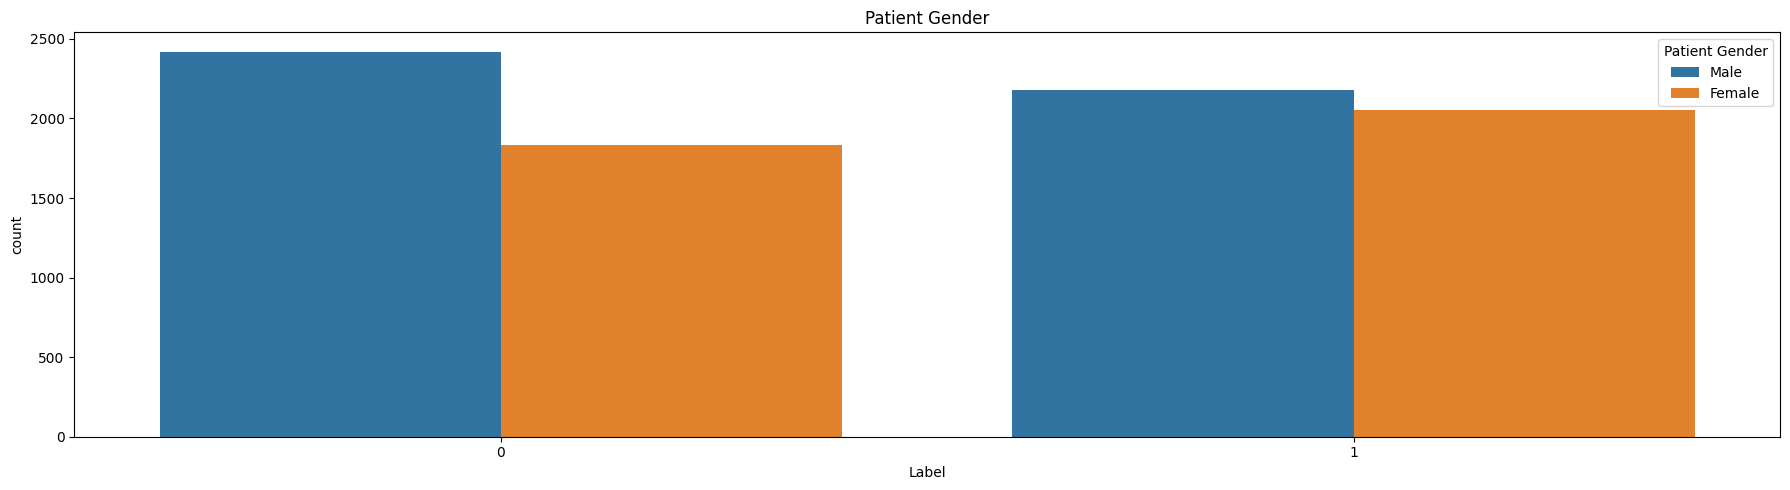

In [31]:
# Training dataset
train_df = extract_dataframe_from_dataset(train_dataset)

# Normalized data
train_df['Age_normalized'] = (train_df['Patient Age'] - train_df['Patient Age'].min()) / (train_df['Patient Age'].max() - train_df['Patient Age'].min())
train_df['FollowUp_normalized'] = (train_df['Follow-up #'] - train_df['Follow-up #'].min()) / (train_df['Follow-up #'].max() - train_df['Follow-up #'].min())

# Count Male: 0, Female: 1
train_df['Gender_numeric'] = train_df['Patient Gender'].map({'M': 0, 'F': 1})

plt.figure(figsize=(18, 5))

# Gender
sns.countplot(x='Pneumothorax', hue='Gender_numeric', data=train_df)
plt.title('Patient Gender')
plt.xlabel('Label')
plt.legend(title='Patient Gender', labels=['Male', 'Female'])

plt.tight_layout()
plt.show()


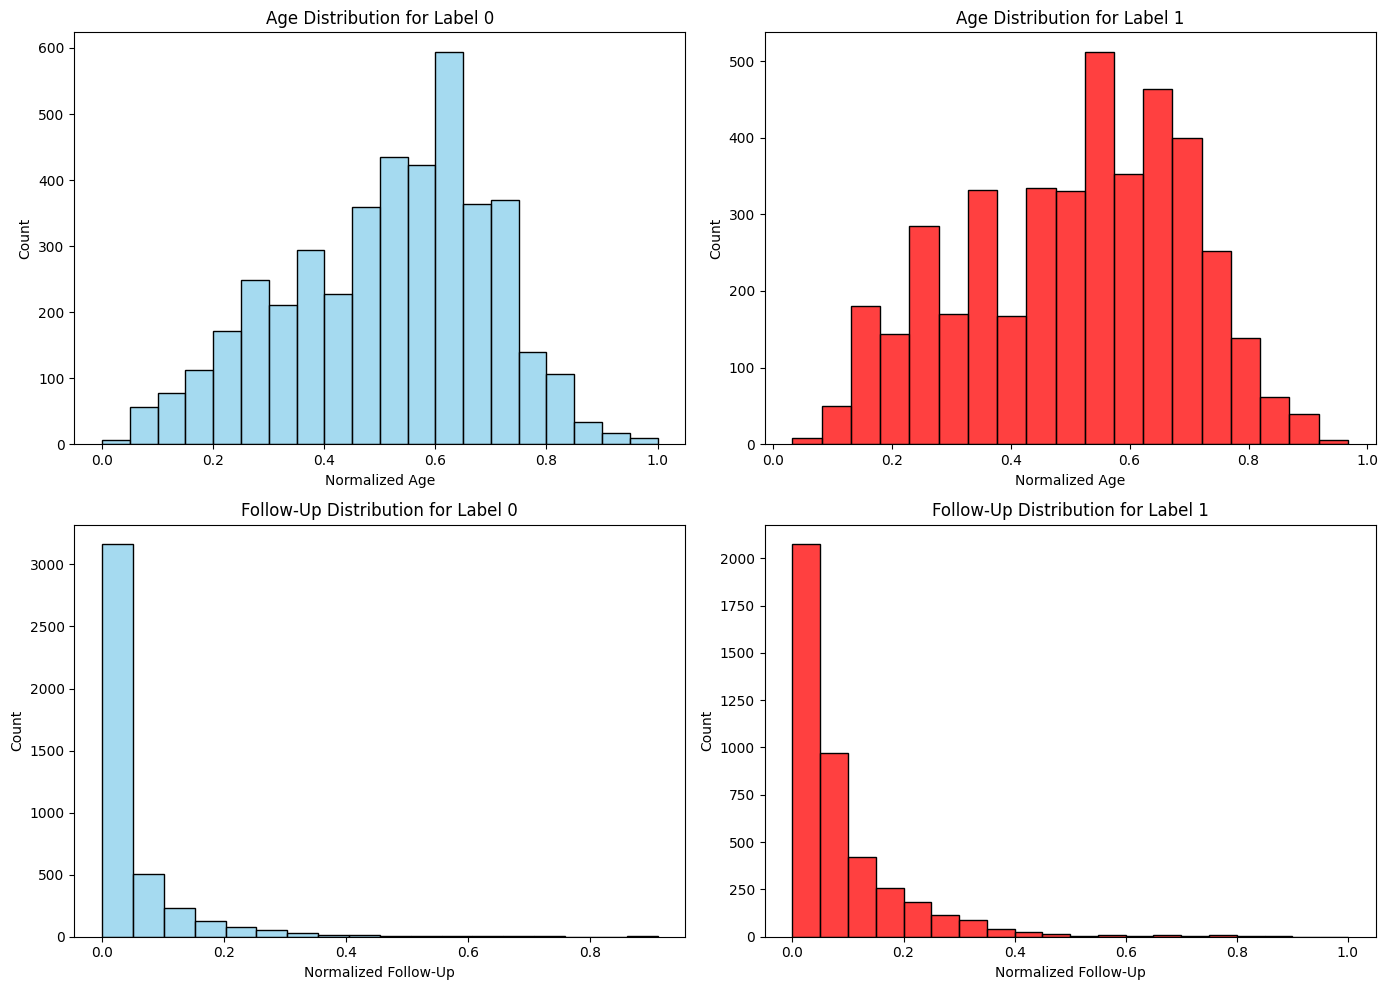

In [23]:
#Separate
label_0_df = train_df[train_df['Pneumothorax'] == 0]
label_1_df = train_df[train_df['Pneumothorax'] == 1]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(label_0_df, x='Age_normalized', kde=False, color="skyblue", ax=axes[0, 0], binwidth=0.05)
axes[0, 0].set_title('Age Distribution for Label 0')
axes[0, 0].set_xlabel('Normalized Age')
axes[0, 0].set_ylabel('Count')


sns.histplot(label_1_df, x='Age_normalized', kde=False, color="red", ax=axes[0, 1], binwidth=0.05)
axes[0, 1].set_title('Age Distribution for Label 1')
axes[0, 1].set_xlabel('Normalized Age')
axes[0, 1].set_ylabel('Count')

sns.histplot(label_0_df, x='FollowUp_normalized', kde=False, color="skyblue", ax=axes[1, 0], binwidth=0.05)
axes[1, 0].set_title('Follow-Up Distribution for Label 0')
axes[1, 0].set_xlabel('Normalized Follow-Up')
axes[1, 0].set_ylabel('Count')

sns.histplot(label_1_df, x='FollowUp_normalized', kde=False, color="red", ax=axes[1, 1], binwidth=0.05)
axes[1, 1].set_title('Follow-Up Distribution for Label 1')
axes[1, 1].set_xlabel('Normalized Follow-Up')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

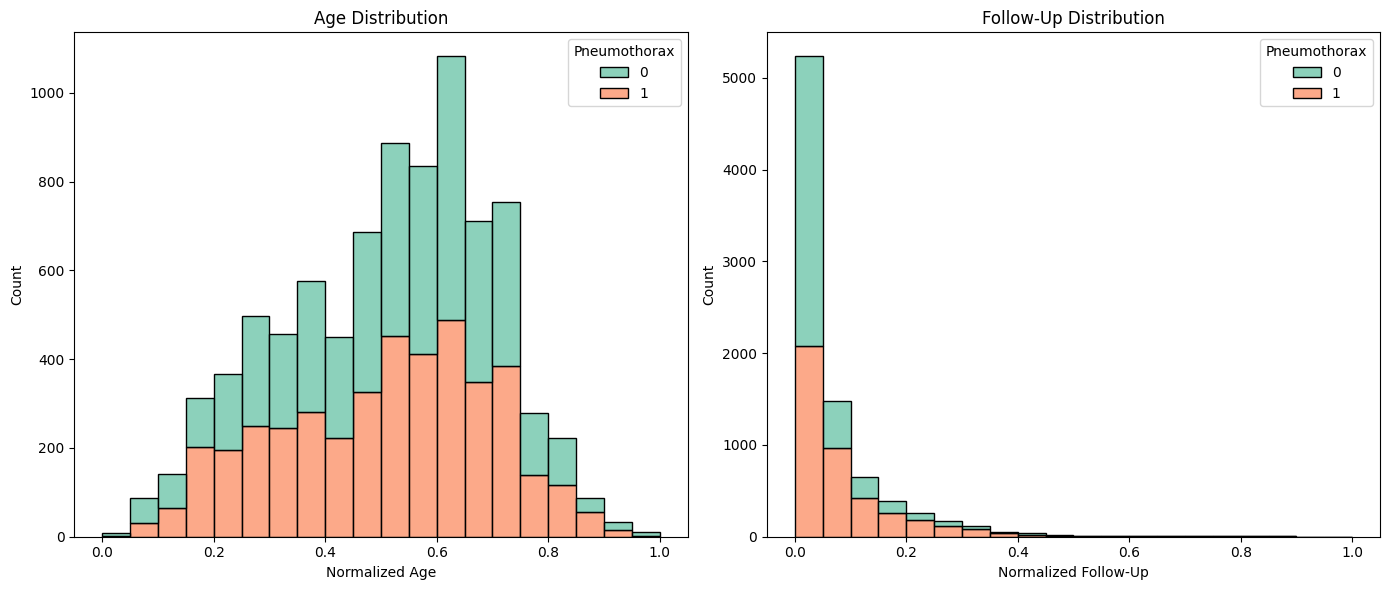

In [25]:
#Merged

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='Age_normalized', hue='Pneumothorax', multiple="stack", kde=False, palette="Set2", binwidth=0.05)
plt.title('Age Distribution')
plt.xlabel('Normalized Age')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x='FollowUp_normalized', hue='Pneumothorax', multiple="stack", kde=False, palette="Set2", binwidth=0.05)
plt.title('Follow-Up Distribution')
plt.xlabel('Normalized Follow-Up')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Follow up ')

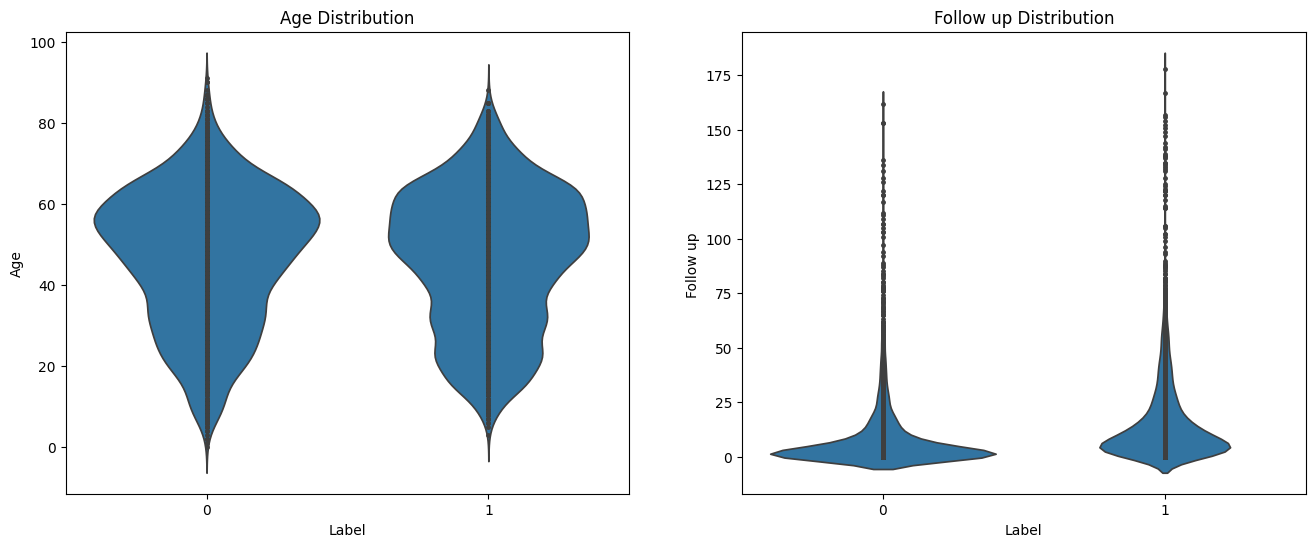

In [32]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.violinplot(x='Pneumothorax', y='Patient Age', data=train_df, inner="point")
plt.title('Age Distribution')
plt.xlabel('Label')
plt.ylabel('Age')

plt.subplot(1, 2, 2)
sns.violinplot(x='Pneumothorax', y='Follow-up #', data=train_df, inner="point")
plt.title('Follow up Distribution')
plt.xlabel('Label')
plt.ylabel('Follow up ')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


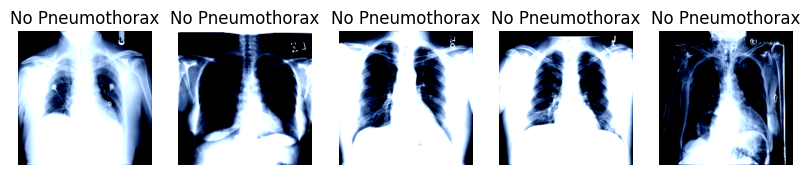

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


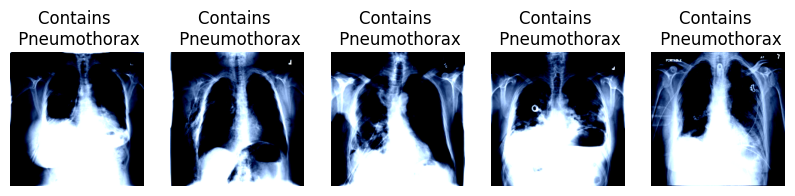

In [31]:
# Collect samples from each class
class_0_samples = []
class_1_samples = []
for images, labels in test_loader:
    for i in range(len(labels)):
        if labels[i] == 0 and len(class_0_samples) < 5:
            class_0_samples.append(images[i])
        elif labels[i] == 1 and len(class_1_samples) < 5:
            class_1_samples.append(images[i])
    if len(class_0_samples) == 5 and len(class_1_samples) == 5:
        break

# No Pneumothorax
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(class_0_samples[i], (1, 2, 0)))
    plt.title("No Pneumothorax")
    plt.axis('off')
plt.show()

# Pneumothorax
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.transpose(class_1_samples[i], (1, 2, 0)))
    plt.title("Contains \n Pneumothorax")
    plt.axis('off')
plt.show()